source: https://data.world/data-society/global-climate-change-data

Import of all needed libraries:

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

getting current working directory:

In [2]:
current_directory = os.getcwd()

Reading data from files:

In [3]:
temperatures = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByCountry2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_state = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByState2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_major_city = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByMajorCity2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

by_country = pd.read_csv(
    os.path.join(
        current_directory,
        "GlobalLandTemperatures/GlobalLandTemperaturesByCountry2.csv"
    ),
    sep=";",
    on_bad_lines="skip"
)

Data joining in one table:

In [6]:
data = pd.concat([temperatures, by_country, by_state, by_major_city], ignore_index=True)

Reformatting date column (1 January 1750 is the start point)

In [7]:
base_date = datetime(1750, 1, 1)
data["dt"] = data["dt"].apply(lambda i: (datetime.strptime(i, "%Y-%m-%d") - base_date).days)

Reformatting string columns: Country, City, State

In [8]:
encoder = OneHotEncoder(sparse=False)

encoded_countries = encoder.fit_transform(data[["Country"]])
encoded_countries_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(["Country"]))

encoded_states = encoder.fit_transform(data[["State"]])
encoded_states_df = pd.DataFrame(encoded_states, columns=encoder.get_feature_names_out(["State"]))

encoded_cities = encoder.fit_transform(data[["City"]])
encoded_cities_df = pd.DataFrame(encoded_cities, columns=encoder.get_feature_names_out(["City"]))

data = data.drop(columns=["Country"]).join(encoded_countries_df)
data = data.drop(columns=["State"]).join(encoded_states_df)
data = data.drop(columns=["City"]).join(encoded_cities_df)

/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/Nataliya/Desktop/university/global-climate-change/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Define the target variable and the input variables. The target variable is the `average monthly temperature`, all other values are input variables

In [9]:
x = data.drop(columns=['AverageTemperature'])
y = data['AverageTemperature']

Splitting data into train and test sets (here is `random state` set to 42, so the results are reproducible. In real life, you should not set it to any value. test_size is set to 0.3, which means that 30% of the data will be used for testing and 70% for training)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 1. Linear regression

Create and train model

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

Test model and calculate mean squared error

In [12]:
y_pred = lin_reg.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

In [13]:
mse

53.609244824552945

Average temperature calculated by model:

In [14]:
y_pred.mean()

14.657252769047354

# 2. Gradient boosting

Create and train model

In [15]:
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

Test model and calculate mean squared error

In [16]:
y_pred_gb = gb_reg.predict(x_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)

In [17]:
mse_gb

87.41293123493541

Average temperature calculated by model:

In [18]:
y_pred_gb.mean()


14.656044562041208

## F-statistics and other classical statistical indicators for evaluating the statistical significance of regression coefficients in linear regression.

In [19]:
import statsmodels.api as sm

x_train_with_const = sm.add_constant(x_train)
lin_reg_sm = sm.OLS(y_train, x_train_with_const).fit()

In [43]:
lin_reg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     AverageTemperature   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     4416.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:57:53   Log-Likelihood:            -4.6241e+06
No. Observations:             1356476   AIC:                         9.249e+06
Df Residuals:                 1355891   BIC:                         9.256e+06
Df Model:                         584                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                25.5334      0.087    292.407      0.000      25.362      25.705
dt                                                -2.248e-05   4.27e-07    -52.706      0.000   -2.33e-05   -2.16e-05
AverageTemperatureUncertainty                        -0.9924      0.008   -119.885      0.000      -1.009      -0.976
Country_Afghanistan                                  -4.3120      0.134    -32.118      0.000      -4.575      -4.049
Country_Africa                                        5.2196      0.142     36.764      0.000       4.941       5.498
Country_Albania                                      -5.5750      0.109    -50.920      0.000      -5.790      -5.360
Country_Algeria                                       4.5561      0.118     38.707      0.000       4.325       4.787
Country_American Samoa                                7.9850      0.152     52.507      0.000       7.687       8.283
Country_Andorra                                      -6.9254      0.110    -62.939      0.000      -7.141      -6.710
Country_Angola                                        3.2739      0.147     22.222      0.000       2.985       3.563
Country_Anguilla                                      7.8869      0.134     58.679      0.000       7.623       8.150
Country_Antigua And Barbuda                           7.6785      0.135     56.965      0.000       7.414       7.943
Country_Argentina                                    -4.1429      0.143    -28.946      0.000      -4.423      -3.862
Country_Armenia                                      -9.5021      0.123    -76.975      0.000      -9.744      -9.260
Country_Aruba                                         9.2293      0.136     67.830      0.000       8.963       9.496
Country_Asia                                        -11.5847      0.127    -90.867      0.000     -11.835     -11.335
Country_Australia                                     2.8066      0.140     20.003      0.000       2.532       3.082
Country_Austria                                     -11.9603      0.110   -109.115      0.000     -12.175     -11.745
Country_Azerbaijan                                   -7.2383      0.125    -57.969      0.000      -7.483      -6.994
Country_Bahamas                                       6.5732      0.124     53.088      0.000       6.330       6.816
Country_Bahrain                                       7.7498      0.138     56.352      0.000       7.480       8.019
Country_Baker Island                                  6.6575      0.141     47.336      0.000       6.382       6.933
Country_Bangladesh                                    6.1274      0.123     49.773      0.000       5.886       6.369
Country_Barbado

In [42]:
lin_reg_sm.fvalue

4416.413477669926

## Error Distribution Visualization: Compare the error distributions for both models to see which model has the smaller error spread.

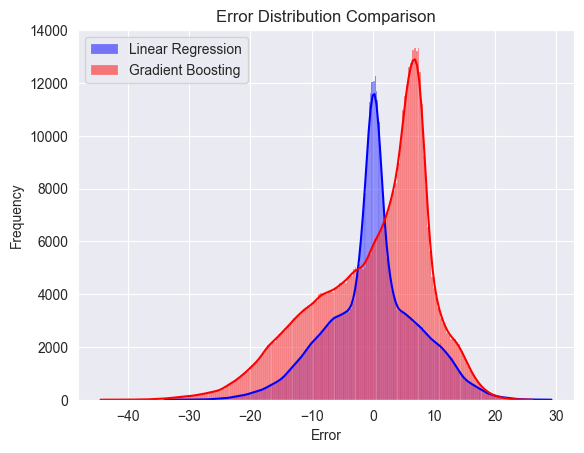

In [25]:
errors_lin = y_test - y_pred
errors_gb = y_test - y_pred_gb

sns.histplot(errors_lin, kde=True, color='blue', alpha=0.5, label='Linear Regression')
sns.histplot(errors_gb, kde=True, color='red', alpha=0.5, label='Gradient Boosting')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error Distribution Comparison')
plt.show()

## Calculation of various metrics such as mean squared error (MSE), mean absolute error (MAE), and coefficient of determination R^2 for each model.

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

# Linear regression
mae_lin = mean_absolute_error(y_test, y_pred)
r2_lin = r2_score(y_test, y_pred)

# Gradient boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Linear regression:")
print(f"Mean squared error: {mse:.4f}")
print(f"Mean absolute error: {mae_lin:.4f}")
print(f"Coefficient of determination R^2: {r2_lin:.4f}")

print("\nGradient boosting:")
print(f"RMS: {mse_gb:.4f}")
print(f"Mean absolute error: {mae_gb:.4f}")
print(f"Coefficient of determination R^2: {r2_gb:.4f}")


Linear regression:
Mean squared error: 53.6092
Mean absolute error: 5.4165
Coefficient of determination R^2: 0.6547

Gradient boosting:
RMS: 87.4129
Mean absolute error: 7.6495
Coefficient of determination R^2: 0.4370


## Visualization of actual values and predictions for both models on the same graph.

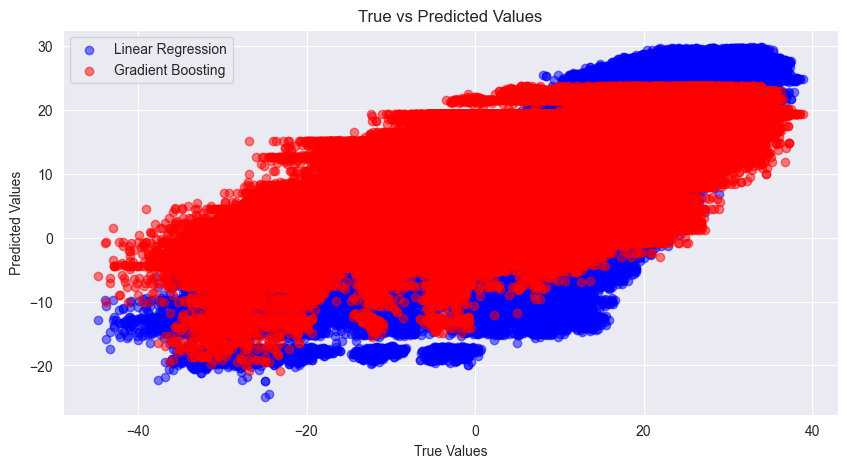

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Linear Regression')
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='red', label='Gradient Boosting')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.show()
